In [1]:
import numpy as np
import pandas as pd
import plotnine as pn

from datetime import datetime, date

from sciterra.mapping.atlas import Atlas
from sciterra.mapping.cartography import Cartographer
from sciterra.vectorization.scibert import SciBERTVectorizer

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
atlas_dir = "outputs/atlas_s2-7-20-23_uncentered_imeletal/"
# atlas_dir = "outputs/atlas_from_cc_region_0/"
# atlas_dir = "outputs/atlas_from_cc_region_8/"

In [3]:
# load atlas
# convert all datetimes to dates
# filter all pubs without citations
# measure density
# measure citations per year
# plot density against citation frequency

In [4]:
atl = Atlas.load(atlas_dir)

In [5]:
len(atl)

24418

In [6]:
vectorizer = SciBERTVectorizer(device="mps")
crt = Cartographer(vectorizer=vectorizer)

Using device: mps.


In [7]:
measurements = crt.measure_topography(atl, metrics=["density", "edginess"])

Computing ['density', 'edginess'] for 24418 publications.


  5%|▍         | 1193/24418 [00:03<00:50, 461.14it/s]divide by zero encountered in divide
invalid value encountered in divide
100%|██████████| 24418/24418 [00:42<00:00, 568.81it/s] 


In [23]:
citations_per_year = [ 
    atl[id].citation_count / (2023 - atl[id].publication_date.year) if (atl[id].publication_date.year < 2023 and atl[id].citation_count is not None) else 0.
    for id in atl.projection.index_to_identifier

]
# what if we just drop all those with 0 citations (per year)?
# and those > 100 anyway
# citations_per_year = [item if (item > 0. and item < 100.) else None for item in citations_per_year ]
# citations_per_year

In [24]:
# count zeros, i.e. where citation_count was zero
len(citations_per_year) - np.count_nonzero(citations_per_year)

1849

In [25]:
df = pd.DataFrame(
    measurements,
    columns=["density", "edginess"],
)
df["citations_per_year"] = citations_per_year
df.dropna(inplace=True)
df

density  edginess  citations_per_year
0      47.420974  0.657229           13.000000
1      41.416734  0.707393            0.000000
2      43.068653  0.656862            0.000000
3      33.426455  0.745734            0.000000
4      43.068197  0.666087            0.000000
...          ...       ...                 ...
24408  27.622119  0.645959           33.423077
24409  33.921786  0.695723            5.807692
24410  31.758704  0.718725           45.333333
24413  32.630743  0.688621           19.375000
24416  33.008719  0.699447            8.320000

[23364 rows x 3 columns]

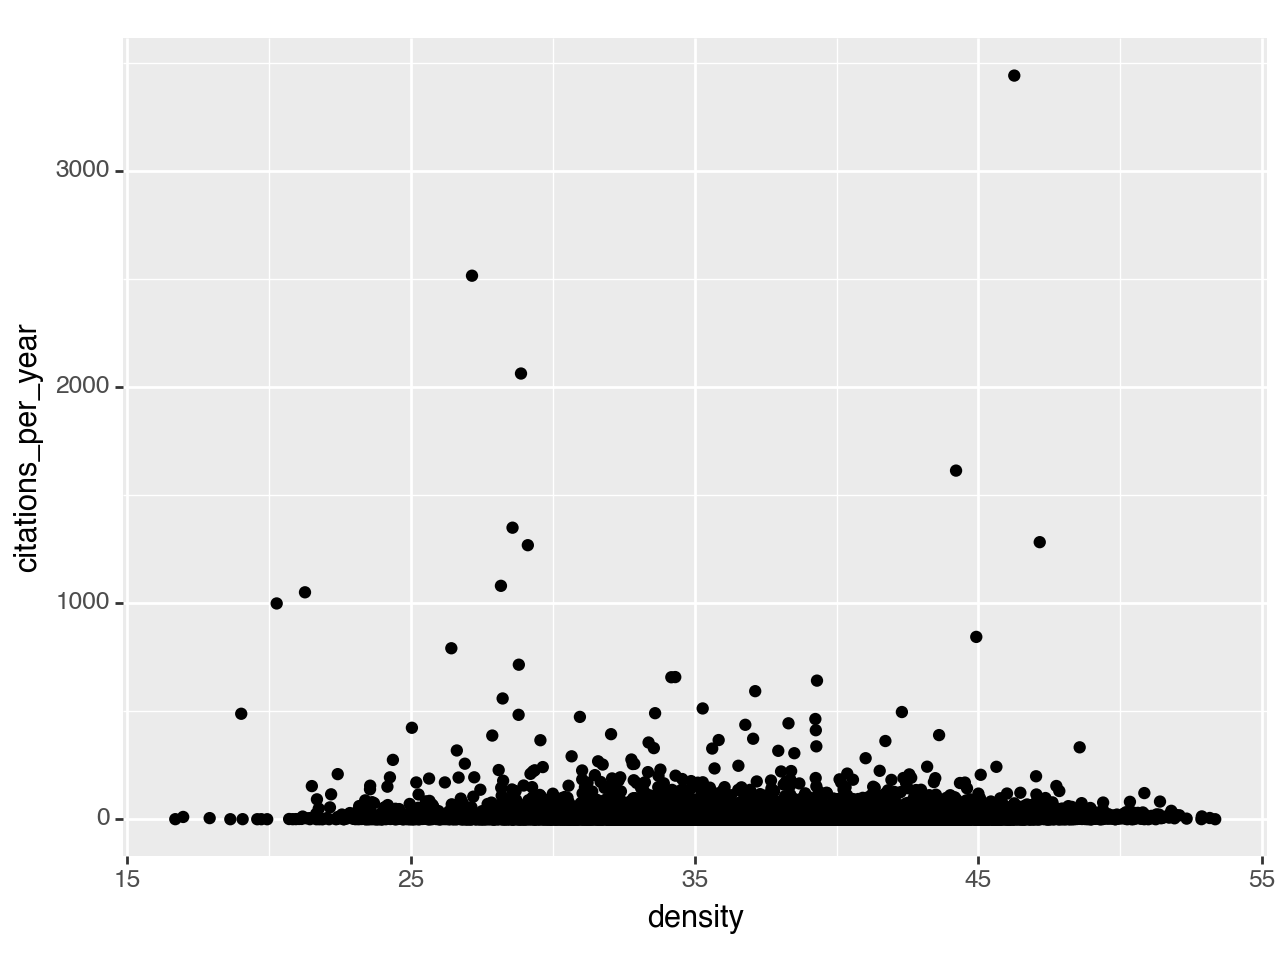

<Figure Size: (640 x 480)>

In [26]:
(
    pn.ggplot(
        df,
        mapping=pn.aes(x="density", y="citations_per_year")
    )
    + pn.geom_point()
    # + pn.geom_smooth(color="orange")
)

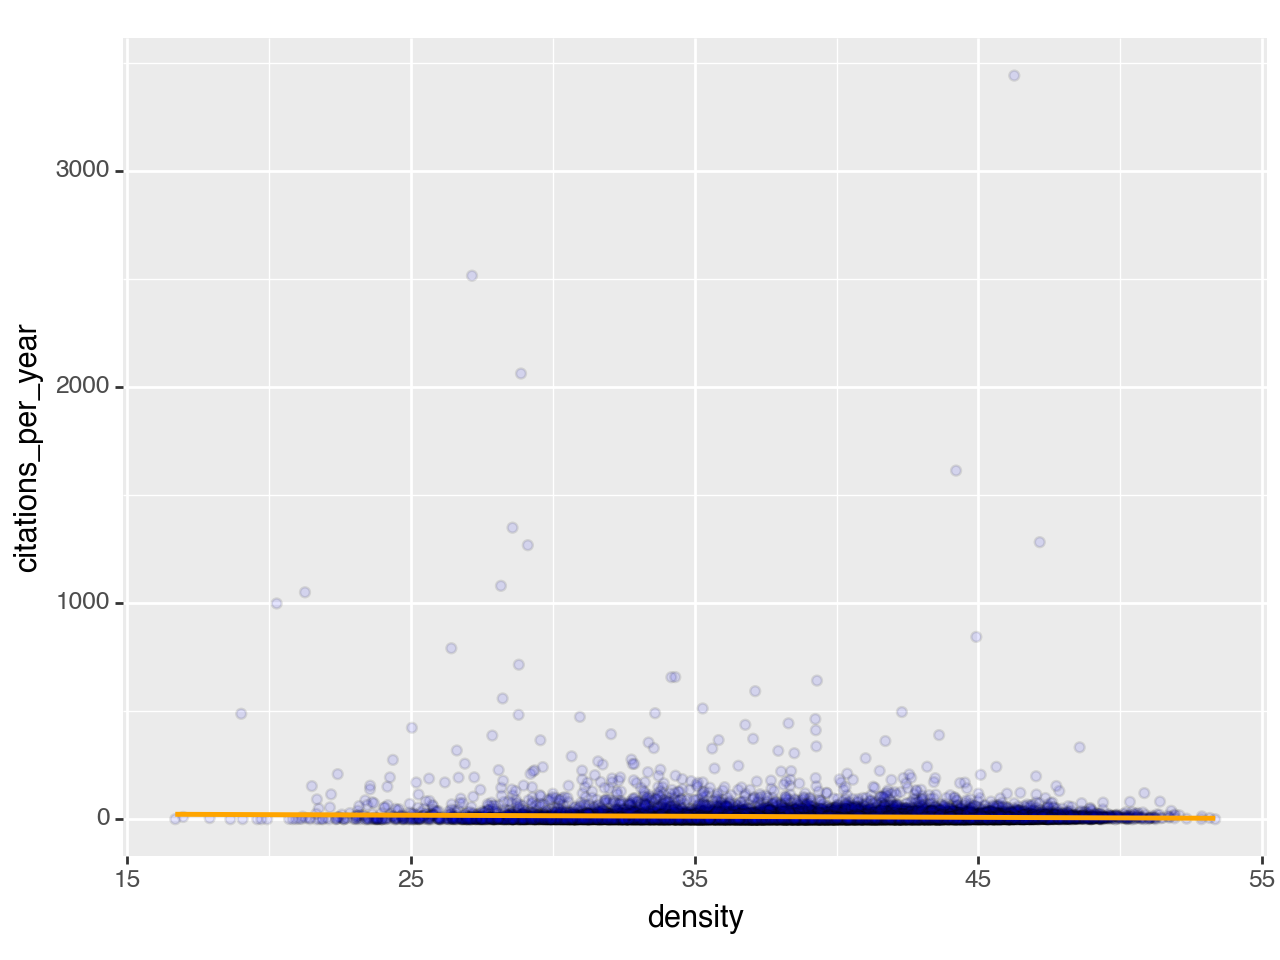

<Figure Size: (640 x 480)>

In [27]:
(
    pn.ggplot(
        df,
        mapping=pn.aes(x="density", y="citations_per_year")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 18)
    # + pn.ylim(0, 100)
)

maybe the reason it seems like citations increase with density is actually not so interesting:

maybe it's that most papers just get few citations and are in the lower to mid range of density. Then when you get to higher density, there citation distribution just becomes more uniform. 

maybe. But why doesn't this argument apply in the other direction -- why does the citations not become more uniform at lower density?

divide by zero encountered in log10


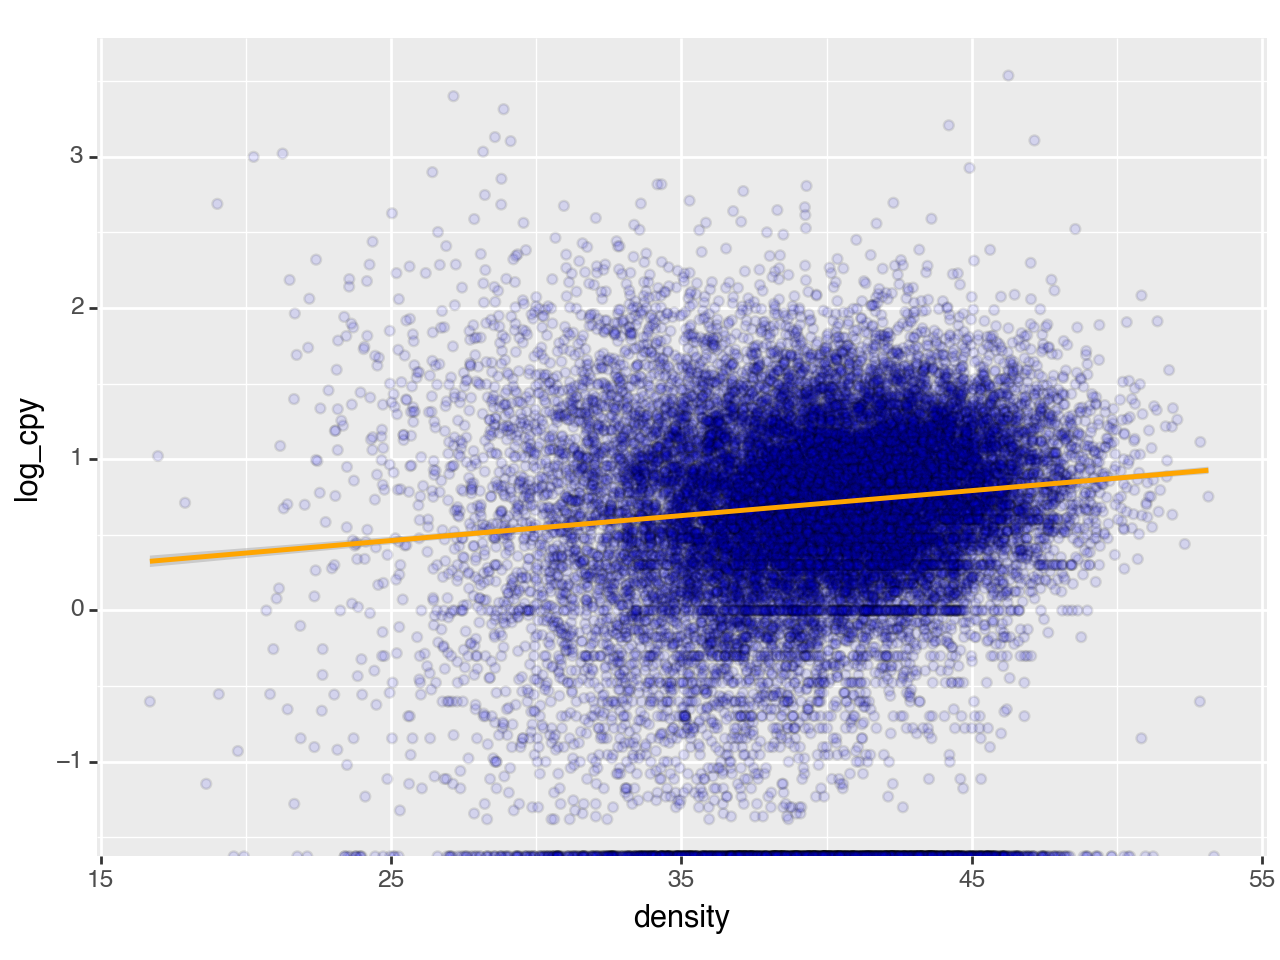

<Figure Size: (640 x 480)>

In [28]:
# log?
df["log_cpy"] = np.log10(df["citations_per_year"])
(
    pn.ggplot(
        df,
        mapping=pn.aes(x="density", y="log_cpy")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 20)
)

geom_point : Removed 242 rows containing missing values.


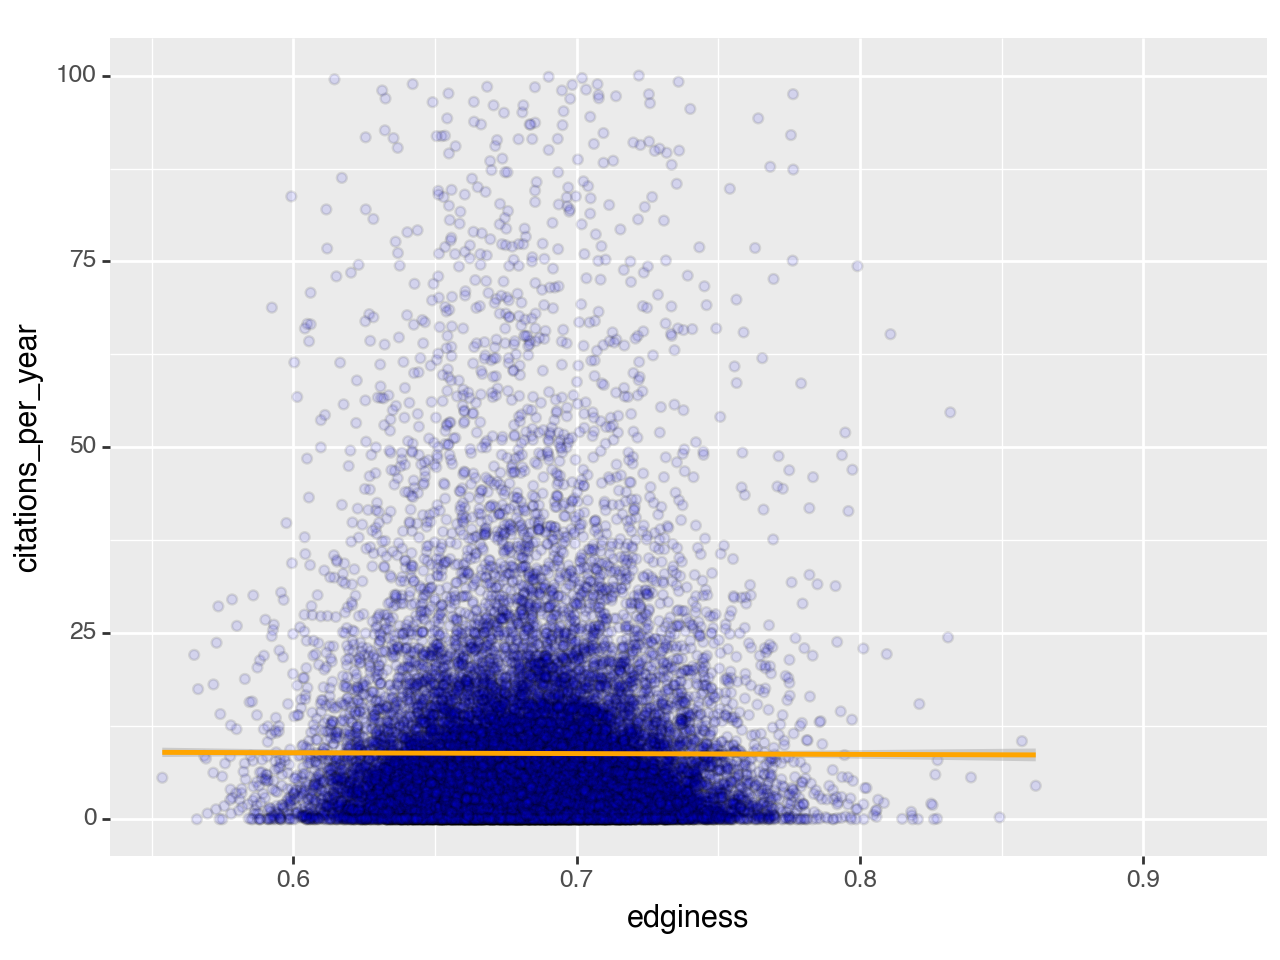

<Figure Size: (640 x 480)>

In [29]:
# asymmetry

(
    pn.ggplot(
        df,
        mapping=pn.aes(x="edginess", y="citations_per_year")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 18)
    + pn.ylim(0, 100)
)

normalizem

In [30]:
density = measurements[:, 0]
edginess = measurements[:, 1]

normalize = lambda arr: (arr - np.nanmean(arr)) / np.nanstd(arr)

density = normalize(density)
edginess = normalize(edginess)

invalid value encountered in subtract
invalid value encountered in subtract


In [31]:
df_n = pd.DataFrame(
    list(zip(density, edginess, citations_per_year)),
    columns=["density", "edginess", "citations_per_year"],
)
df_n

density  edginess  citations_per_year
0          NaN -0.745227           13.000000
1          NaN  0.711946            0.000000
2          NaN -0.755905            0.000000
3          NaN  1.825683            0.000000
4          NaN -0.487914            0.000000
...        ...       ...                 ...
24413      NaN  0.166655           19.375000
24414      NaN       NaN            2.615385
24415      NaN       NaN            4.733333
24416      NaN  0.481115            8.320000
24417      NaN       NaN           19.772727

[24418 rows x 3 columns]

geom_point : Removed 24418 rows containing missing values.


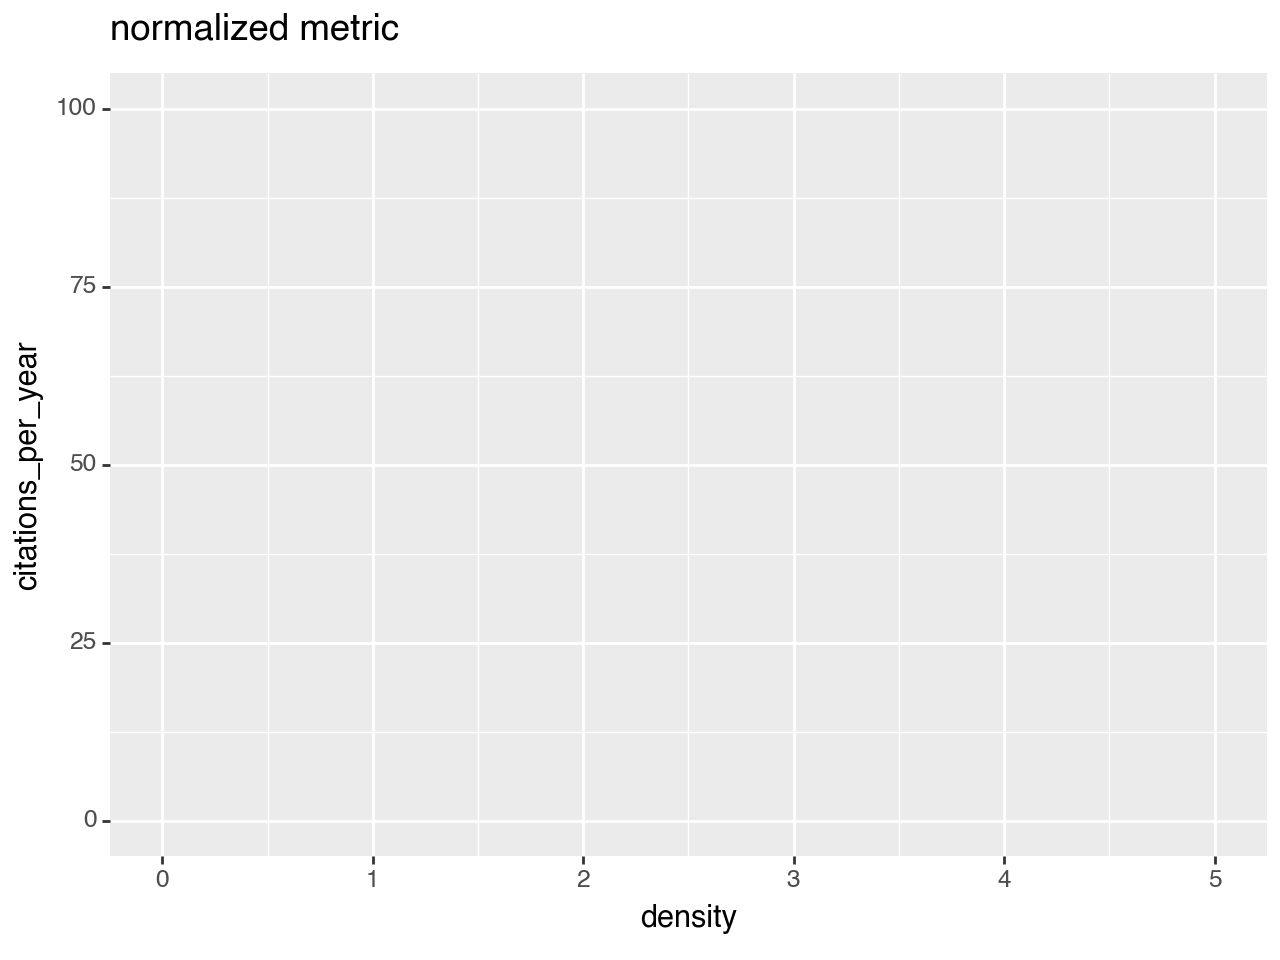

<Figure Size: (640 x 480)>

In [32]:
# This doesn't make much sense because edginess is already normalized to 0,1
(
    pn.ggplot(
        df_n,
        mapping=pn.aes(x="density", y="citations_per_year")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    + pn.xlim(0, 5)
    + pn.ylim(0, 100)
    + pn.ggtitle("normalized metric")
)

geom_point : Removed 7386 rows containing missing values.


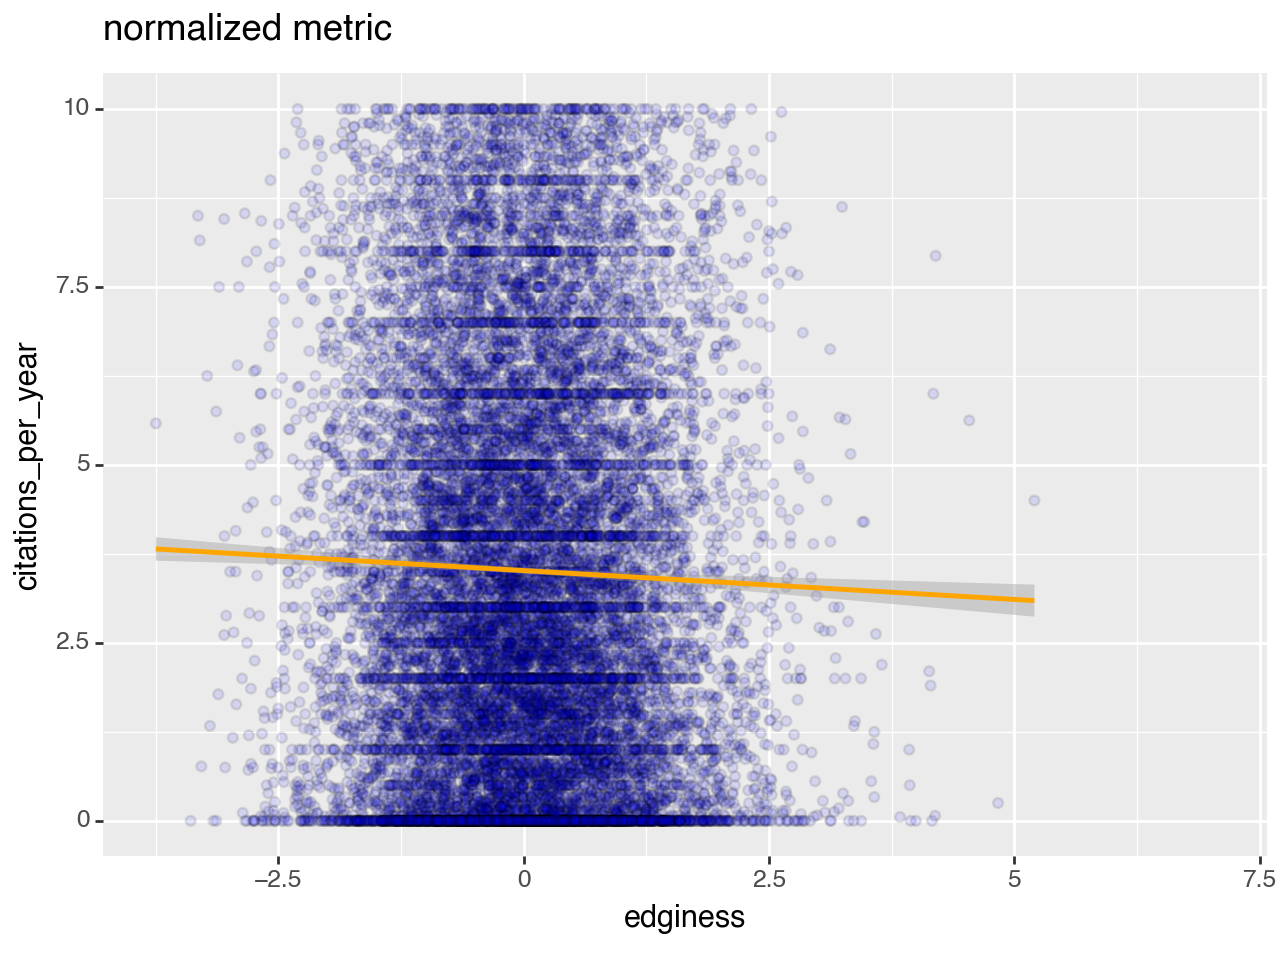

<Figure Size: (640 x 480)>

In [33]:
# This doesn't make much sense because edginess is already normalized to 0,1
(
    pn.ggplot(
        df_n,
        mapping=pn.aes(x="edginess", y="citations_per_year")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 18)
    + pn.ylim(0, 10)
    + pn.ggtitle("normalized metric")
)

In [34]:
np.std(citations_per_year)

46.06756882218994

In [35]:
np.mean(citations_per_year)

11.634959651157503

against each other

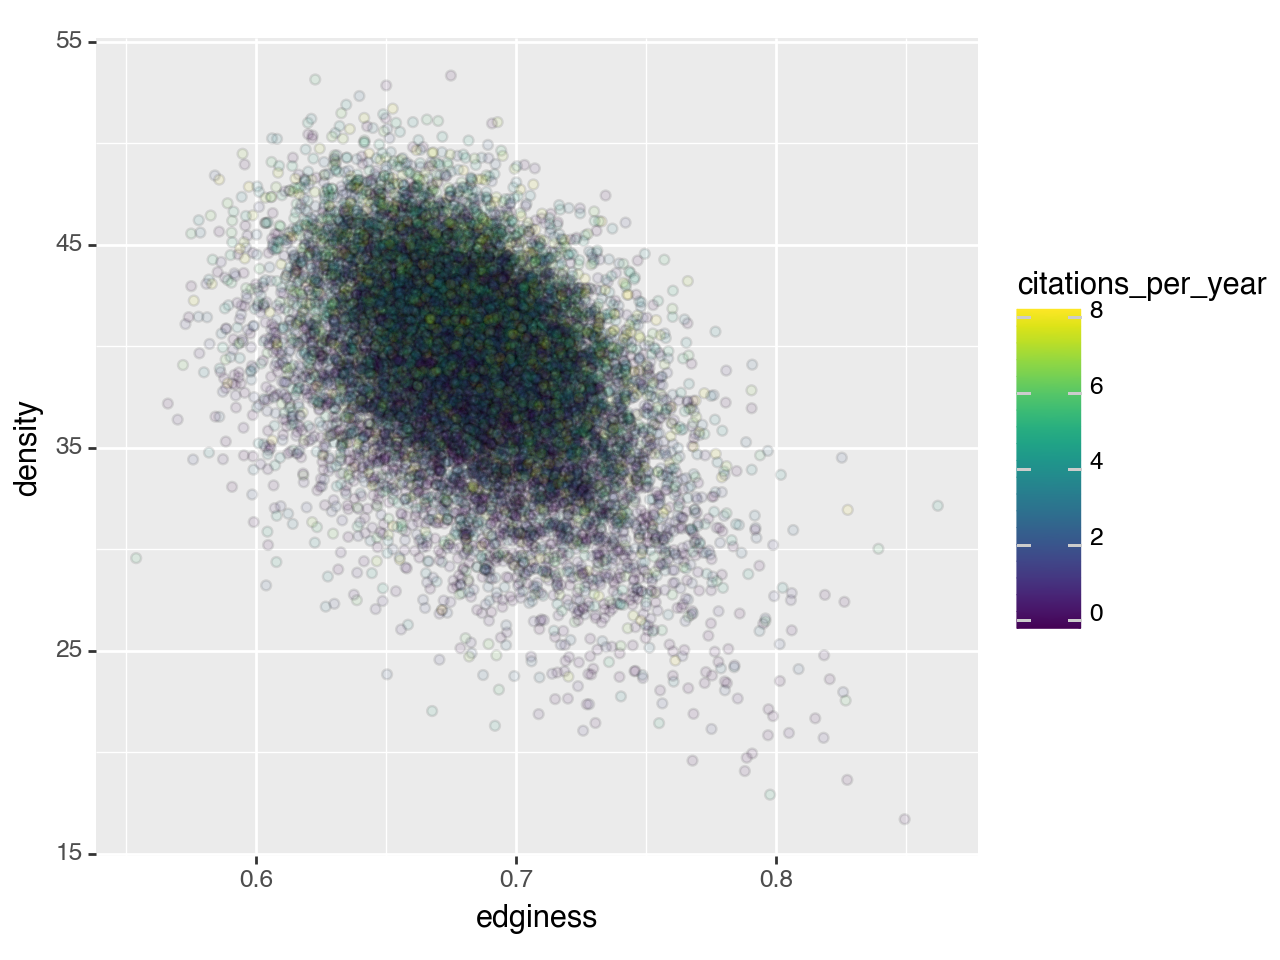

<Figure Size: (640 x 480)>

In [40]:
# not normalized

# also remove citations per year more than a few std devs
# for now just truncate after 100
df_a = df[df["citations_per_year"] <= 8] # or even less

# how to reduce overplotting? Can I make the hotter colors appear on top?
(
    pn.ggplot(
        df_a,
        mapping=pn.aes(x="edginess", y="density")
    )
    + pn.geom_point(
        # fill="blue", 
        mapping=pn.aes(fill="citations_per_year"),
        alpha=0.1,
        )
)

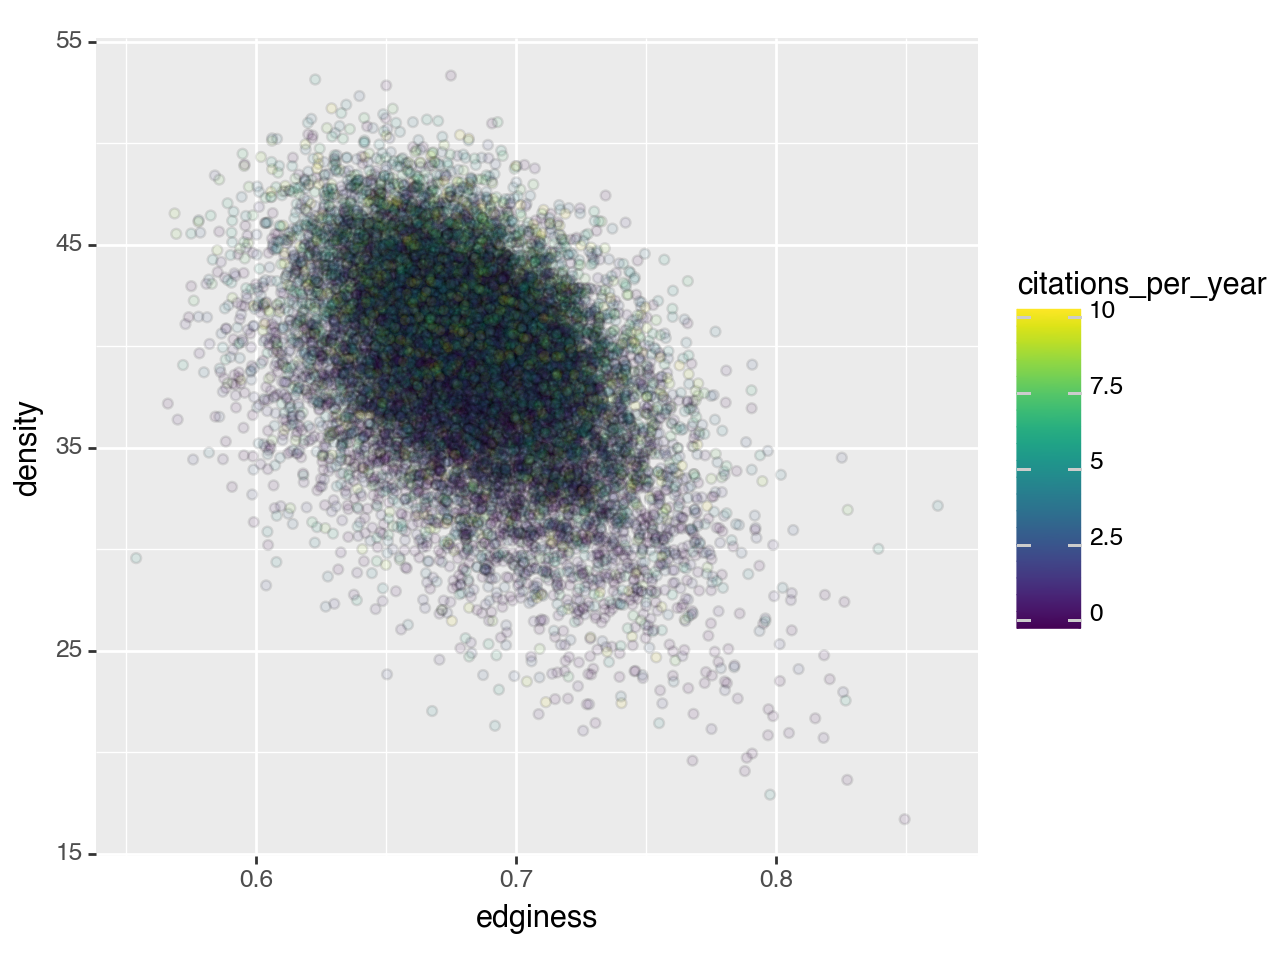

<Figure Size: (640 x 480)>

In [41]:
# let's only plot pubs for high cites per year
df_b = df[df["citations_per_year"] >= 0]
df_b = df[df["citations_per_year"] <= 10]

# how to reduce overplotting? Can I make the hotter colors appear on top?
(
    pn.ggplot(
        df_b,
        mapping=pn.aes(x="edginess", y="density")
    )
    + pn.geom_point(
        # fill="blue", 
        mapping=pn.aes(fill="citations_per_year"),
        alpha=0.1,
        )
)

this does not look like the distribution that zach had.